<a href="https://colab.research.google.com/github/netaamz/DL-Model-for-Automated-Detection-of-Meniscus-Tears-in-Knee-MRI-Images/blob/main/3_planes_DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone: Development of an algorithm for automatic detection of meniscus tears in radiographic images of the knee.

Important note: a pre processing is required, avilable notebook via github

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:

!pip install tensorflow
!pip install keras
!pip install sklearn
!pip install opencv-python
!pip install matplotlib
!pip install numpy

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


## Data import

**Data from [MRNet](https://stanfordmlgroup.github.io/competitions/mrnet/):**
* Images of 1370 knee MRI exams performed at Stanford University Medical Center. The dataset contains 1,104 (80.6%) abnormal exams,  with 319 (23.3%) ACL tears and 508 (37.1%) meniscal tears; labels were obtained through manual extraction from clinical reports.
* train set: consists of 1130 MRI images from coronal, sagittal and transverse planes
* validation set: consists of 120 MRI images from coronal, sagittal and transverse planes


Connect google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data generation for meniscus
The dataset contains *s* x 256 x 256 images. Since middle images are the most useful, only 3 middle slides in the series are retained.


In [4]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
def data_gen(dataset_type, plane, diagnosis):
    '''this function gets the data from the extracted datset'''

    if dataset_type == 'train':
        go = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/train_transformf' # if we want without filter then:  /content/drive/My Drive/miniscus data set/MRNet-v1.0/train_transform
    else:
        go = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/valid_transformf' # if we want without filter then: /content/drive/My Drive/miniscus data set/MRNet-v1.0/valid_transform

    plane_dir = f'{go}/{plane}.npy'

    data = np.load(plane_dir)
    label_path = f'/content/drive/My Drive/miniscus data set/MRNet-v1.0/{dataset_type}-{diagnosis}.csv'

    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])

    return(data, label_data)


Note that training data for all planes are the same. Only labels are different.

In [5]:
# generate training input
coronal_mensicus, coronal_mensicus_label = data_gen('train', 'coronal/extracted_images', 'meniscus')
axial_mensicus, axial_mensicus_label = data_gen('train', 'axial/extracted_images', 'meniscus')
sagittal_mensicus, sagittal_mensicus_label = data_gen('train', 'sagittal/extracted_images', 'meniscus')
print(sagittal_mensicus.shape)
# generate validation
coronal_mensicus_val, coronal_mensicus_label_val  = data_gen('valid', 'coronal/extracted_images', 'meniscus')
axial_mensicus_val, axial_mensicus_label_val  = data_gen('valid', 'axial/extracted_images', 'meniscus')
sagittal_mensicus_val, sagittal_mensicus_label_val  = data_gen('valid', 'sagittal/extracted_images', 'meniscus')

(1130, 256, 256, 3)


In [6]:
sagittal_mensicus_val.view

<function ndarray.view>

In [7]:
from keras.utils import to_categorical  # Import to_categorical
base_path = "/content/drive/My Drive/miniscus data set/MRNet-v1.0/"

num_classes =2

sagittal_mensicus_label = to_categorical(sagittal_mensicus_label, num_classes)
sagittal_mensicus_label_val = to_categorical(sagittal_mensicus_label_val, num_classes)

coronal_mensicus_label = to_categorical(coronal_mensicus_label, num_classes)
coronal_mensicus_label_val = to_categorical(coronal_mensicus_label_val, num_classes)

axial_mensicus_label = to_categorical(axial_mensicus_label, num_classes)
axial_mensicus_label_val = to_categorical(axial_mensicus_label_val, num_classes)


## Model Architecture

The model is designed to classify grayscale MRI images for detecting normal menisci or meniscus tears. The input images, resized to 256x256x3, undergo preprocessing steps, including splicing and applying a White Top Hat filter to enhance features.
* The preprocessed images are then fed into a pre-trained DenseNet121
architecture, which has been modified to exclude its top classification layers.
* The DenseNet121 model processes the input and outputs feature maps, which are subsequently passed through a Global Average Pooling layer, reducing the spatial dimensions into a 1D vector.
* A Batch Normalization layer is applied to stabilize the network and improve learning performance.
* The feature vector is then fed into a Dense Layer with 1024 units and ReLU activation to extract high-level features, followed by a Dropout Layer to mitigate overfitting.
A second Dense Layer, also with 1024 units and ReLU activation, further refines the feature space.
* Finally, the model outputs predictions through a Dense Layer with 2 units and sigmoid activation, representing the probabilities of the two classes (normal or meniscus tear).

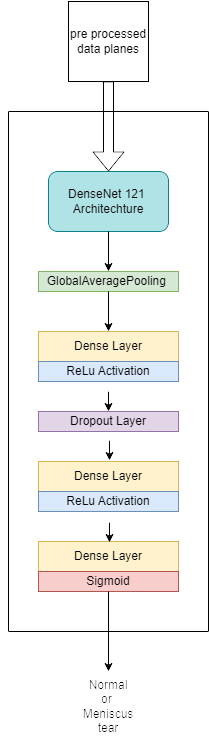

In [8]:
import tensorflow as tf
import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Lambda, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint


def create_model(input_shape, num_classes, dropout):
    # Load the pre-trained DenseNet121 model
    base_model = DenseNet121(weights=None, include_top=False, pooling=None,input_shape=input_shape)
    input_tensor = Input(shape=input_shape)
    x = base_model(input_tensor)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(1024, activation='relu')(x)
    output = Dense(num_classes, activation='sigmoid')(x)
    # Create the final model
    model = Model(inputs=input_tensor, outputs=output)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    return model

##  Hyperparameters
define hyper parameters for training

In [9]:
    # Define your parameters
    img_rows, img_cols = 256, 256
    channel = 3
    batch_size = 32
    nb_epoch = 100
    dropout = 0.4
    lr = 5e-4  # Learning rate

## Train

In [10]:
import tensorflow as tf
import keras

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint


if __name__ == '__main__':
    # Create the model
    input_shape = (img_rows, img_cols, channel)
    model_axial = create_model(input_shape, num_classes, dropout)
    model_coronal = create_model(input_shape, num_classes, dropout)
    model_sagittal = create_model(input_shape, num_classes, dropout)

    # Compile the model

    model_axial.compile(optimizer=SGD(learning_rate=lr, momentum=0.9),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model_coronal.compile(optimizer=SGD(learning_rate=lr, momentum=0.9),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model_sagittal.compile(optimizer=SGD(learning_rate=lr, momentum=0.9),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Set up the checkpoint
    filepath = "bestmodel.keras"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]


    # Train the model - axial
    history_axial = model_axial.fit(axial_mensicus, axial_mensicus_label,
                        batch_size=batch_size,
                        epochs=nb_epoch,
                        shuffle=True,
                        verbose=1,
                        validation_data=(axial_mensicus_val, axial_mensicus_label_val),
                        callbacks=callbacks_list)

    # Train the model - coronal
    history_coronal = model_coronal.fit(coronal_mensicus, coronal_mensicus_label,
                        batch_size=batch_size,
                        epochs=nb_epoch,
                        shuffle=True,
                        verbose=1,
                        validation_data=(coronal_mensicus_val, coronal_mensicus_label_val),
                        callbacks=callbacks_list)

    # Train the model- sagittal
    history_sagittal = model_sagittal.fit(sagittal_mensicus, sagittal_mensicus_label,
                        batch_size=batch_size,
                        epochs=nb_epoch,
                        shuffle=True,
                        verbose=1,
                        validation_data=(sagittal_mensicus_val, sagittal_mensicus_label_val),
                        callbacks=callbacks_list)





Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.5574 - loss: 1.1927
Epoch 1: val_accuracy improved from -inf to 0.43333, saving model to bestmodel.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 59s 928ms/step - accuracy: 0.5576 - loss: 1.1917 - val_accuracy: 0.4333 - val_loss: 0.7237
Epoch 2/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5593 - loss: 1.0008
Epoch 2: val_accuracy improved from 0.43333 to 0.56667, saving model to bestmodel.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.5598 - loss: 0.9973 - val_accuracy: 0.5667 - val_loss: 0.6972
Epoch 3/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5941 - loss: 0.8233
Epoch 3: val_accuracy did not improve from 0.56667
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.5936 - loss: 0.8208 - val_accuracy: 0.5667 - val_loss: 0.6873
Epoch 4/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6382 - loss: 0.7143
Epoch 4: val_accuracy did not improve from 0.56667
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s

## Predict

In [ ]:
# Make predictions for each plane
predictions_valid_axial = model_axial.predict(axial_mensicus_val, batch_size=batch_size, verbose=1)
predictions_valid_coronal = model_coronal.predict(coronal_mensicus_val, batch_size=batch_size, verbose=1)
predictions_valid_sagittal = model_sagittal.predict(sagittal_mensicus_val, batch_size=batch_size, verbose=1)

## Evaluate

In [12]:
import numpy as np
def calculate_accuracy(ypred, ytest):
    '''calculate accuracy and misclassification'''
    total = 0
    accurate = 0
    accurateindex = []
    wrongindex = []

    for i in range(len(ypred)):
        if np.argmax(ypred[i]) == np.argmax(ytest[i]):
            accurate += 1
            accurateindex.append(i)
        else:
            wrongindex.append(i)
        total += 1

    accuracy = round(accurate / total * 100, 3)
    return total, accurate, total - accurate, accuracy, accurateindex, wrongindex

In [17]:


from sklearn.metrics import log_loss

score_axial = log_loss(axial_mensicus_label_val, predictions_valid_axial)
score_coronal = log_loss(coronal_mensicus_label_val, predictions_valid_coronal)
score_sagittal = log_loss(sagittal_mensicus_label_val, predictions_valid_sagittal)

print(f"Log Loss: {score_axial}")
print(f"Log Loss: {score_coronal}")
print(f"Log Loss: {score_sagittal}")

# Axial plane accuracy
total_axial, accurate_axial, wrong_axial, accuracy_axial, accurateindex_axial, wrongindex_axial = calculate_accuracy(predictions_valid_axial, axial_mensicus_label_val)
print('Axial - Total test data:', total_axial, '\tAccurately predicted data:', accurate_axial, '\tWrongly predicted data:', wrong_axial)
print('Axial Accuracy:', accuracy_axial, '%')

# Coronal plane accuracy
total_coronal, accurate_coronal, wrong_coronal, accuracy_coronal, accurateindex_coronal, wrongindex_coronal = calculate_accuracy(predictions_valid_coronal, coronal_mensicus_label_val)
print('Coronal - Total test data:', total_coronal, '\tAccurately predicted data:', accurate_coronal, '\tWrongly predicted data:', wrong_coronal)
print('Coronal Accuracy:', accuracy_coronal, '%')

# Sagittal plane accuracy
total_sagittal, accurate_sagittal, wrong_sagittal, accuracy_sagittal, accurateindex_sagittal, wrongindex_sagittal = calculate_accuracy(predictions_valid_sagittal, sagittal_mensicus_label_val)
print('Sagittal - Total test data:', total_sagittal, '\tAccurately predicted data:', accurate_sagittal, '\tWrongly predicted data:', wrong_sagittal)
print('Sagittal Accuracy:', accuracy_sagittal, '%')


Log Loss: 0.6847849166092639
Log Loss: 0.6982790988730045
Log Loss: 0.6905422058677276
Axial - Total test data: 120 	Accurately predicted data: 68 	Wrongly predicted data: 52
Axial Accuracy: 56.667 %
Coronal - Total test data: 120 	Accurately predicted data: 68 	Wrongly predicted data: 52
Coronal Accuracy: 56.667 %
Sagittal - Total test data: 120 	Accurately predicted data: 68 	Wrongly predicted data: 52
Sagittal Accuracy: 56.667 %


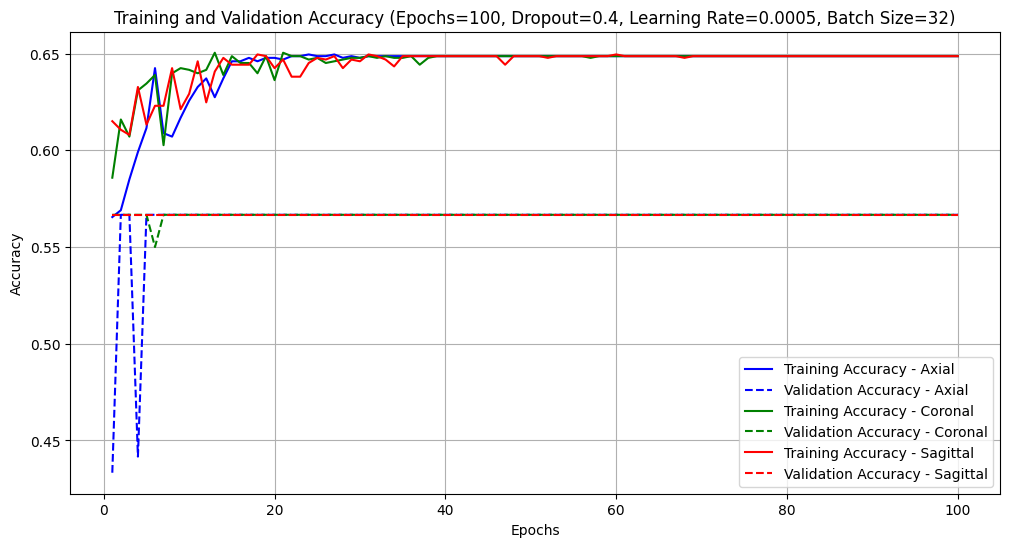

<Figure size 640x480 with 0 Axes>

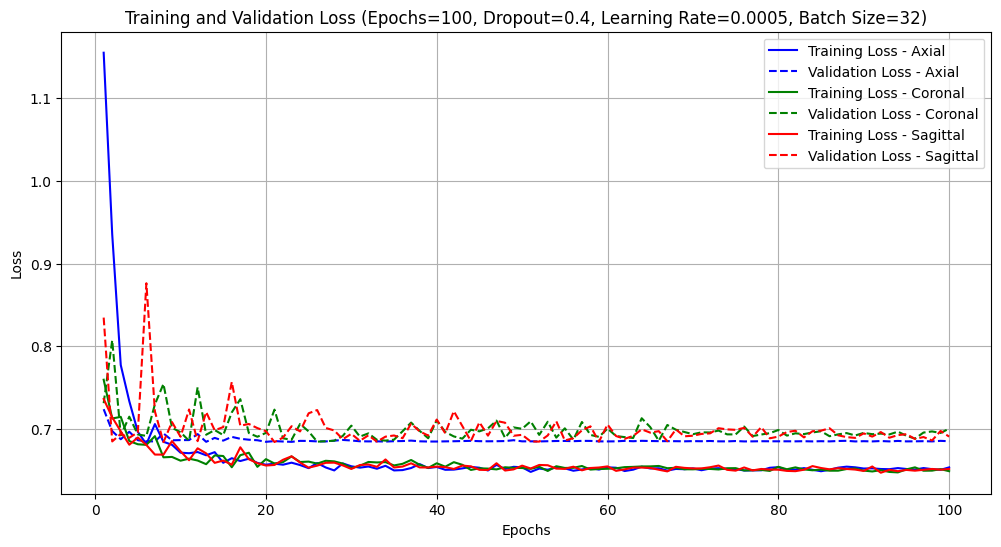

In [18]:
# Evaluating Accuracy and Loss for the three planes: axial, coronal, and sagittal
%matplotlib inline
import matplotlib.pyplot as plt

# Axial metrics
acc_axial = history_axial.history['accuracy']
val_acc_axial = history_axial.history['val_accuracy']
loss_axial = history_axial.history['loss']
val_loss_axial = history_axial.history['val_loss']

# Coronal metrics
acc_coronal = history_coronal.history['accuracy']
val_acc_coronal = history_coronal.history['val_accuracy']
loss_coronal = history_coronal.history['loss']
val_loss_coronal = history_coronal.history['val_loss']

# Sagittal metrics
acc_sagittal = history_sagittal.history['accuracy']
val_acc_sagittal = history_sagittal.history['val_accuracy']
loss_sagittal = history_sagittal.history['loss']
val_loss_sagittal = history_sagittal.history['val_loss']
epochs = range(1, len(acc_axial) + 1)
# Plot training and validation accuracy for each plane
plt.figure(figsize=(12, 6))
plt.plot(epochs, acc_axial, 'b', label='Training Accuracy - Axial')
plt.plot(epochs, val_acc_axial, 'b--', label='Validation Accuracy - Axial')
plt.plot(epochs, acc_coronal, 'g', label='Training Accuracy - Coronal')
plt.plot(epochs, val_acc_coronal, 'g--', label='Validation Accuracy - Coronal')
plt.plot(epochs, acc_sagittal, 'r', label='Training Accuracy - Sagittal')
plt.plot(epochs, val_acc_sagittal, 'r--', label='Validation Accuracy - Sagittal')

plt.title(f'Training and Validation Accuracy (Epochs={nb_epoch}, Dropout={dropout}, Learning Rate={lr}, Batch Size={batch_size})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(f'Train_val_acc_all_planes_Ep={nb_epoch}_Do={dropout}_Lr={lr}_Bs={batch_size}.png')

plt.figure()

# Plot training and validation loss for each plane
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_axial, 'b', label='Training Loss - Axial')
plt.plot(epochs, val_loss_axial, 'b--', label='Validation Loss - Axial')
plt.plot(epochs, loss_coronal, 'g', label='Training Loss - Coronal')
plt.plot(epochs, val_loss_coronal, 'g--', label='Validation Loss - Coronal')
plt.plot(epochs, loss_sagittal, 'r', label='Training Loss - Sagittal')
plt.plot(epochs, val_loss_sagittal, 'r--', label='Validation Loss - Sagittal')

plt.title(f'Training and Validation Loss (Epochs={nb_epoch}, Dropout={dropout}, Learning Rate={lr}, Batch Size={batch_size})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(f'Train_val_loss_all_planes_Ep={nb_epoch}_Do={dropout}_Lr={lr}_Bs={batch_size}.png')

plt.show()


save the models in a keras file

In [19]:
model_axial.save("model_axial.keras")
model_coronal.save("model_coronal.keras")
model_sagittal.save("model_sagittal.keras")

In [20]:
from google.colab import files
files.download('model_coronal.keras')
files.download("model_sagittal.keras")
files.download("model_axial.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
files.download("Train_val_acc_all_planes_Ep=100_Do=0.4_Lr=0.0005_Bs=32.png")
files.download("Train_val_loss_all_planes_Ep=100_Do=0.4_Lr=0.0005_Bs=32.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>